In [1]:
import os
import sys
import numpy as np
import pandas as pd
import xarray as xr
import scipy.linalg as LA

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
plt.rcParams['text.usetex'] = True

In [2]:
fp = '../Synthetic/farinotti_corrected/dx50/hysteresis/smoothBed_SS_IC/hdf5/'

files   = sorted([os.path.join(fp,file) for file in os.listdir(fp) if file.endswith('.nc') and '2000a' in file])
xarrays = []

for file in files:
    #if '2.26' not in file: 
    xarrays.append(xr.open_dataset(file))

SmoothBed_SS_IC = xr.concat(xarrays, 
                       pd.Index(data = np.arange(1.90, 2.051, 0.01),  name='Delta_MB'))
                       #pd.Index(data = np.delete(np.arange(2.00, 2.51, 0.01),26),  name='Delta_MB'))
    
SmoothBed_SS_IC['z_s'] = SmoothBed_SS_IC.z_s.where((SmoothBed_SS_IC.z_s - SmoothBed_SS_IC.z_b) != 10., SmoothBed_SS_IC.z_b)
SmoothBed_SS_IC["H"]   = SmoothBed_SS_IC.z_s - SmoothBed_SS_IC.z_b

In [3]:
fp = '../Synthetic/farinotti_corrected/dx50/hysteresis/observed_IC/hdf5/'

files   = sorted([os.path.join(fp,file) for file in os.listdir(fp) if file.endswith('.nc') and '2000a' in file])
xarrays = []

for file in files:
    #if '2.26' not in file: 
    xarrays.append(xr.open_dataset(file))

Observed_IC = xr.concat(xarrays, 
                       pd.Index(data = np.arange(1.90, 2.051, 0.01), name='Delta_MB'))
                       #pd.Index(data = np.delete(np.arange(2.00, 2.51, 0.01),26), name='Delta_MB'))

Observed_IC['z_s'] = Observed_IC.z_s.where((Observed_IC.z_s - Observed_IC.z_b) != 10., Observed_IC.z_b)
Observed_IC["H"]   = Observed_IC.z_s - Observed_IC.z_b

In [4]:
OIC_vol = Observed_IC.H.integrate("x")     / Observed_IC.H.sel(t=1).integrate("x")
SIC_vol = SmoothBed_SS_IC.H.integrate("x") / Observed_IC.H.sel(t=1).integrate("x")

In [5]:
############################################################
# For Seting up the colorbar: 
#    - http://csc.ucdavis.edu/~jmahoney/matplotlib-tips.html
############################################################

colormap = cm.plasma
normalize = mcolors.Normalize(vmin=np.min(Observed_IC.Delta_MB), vmax=np.max(Observed_IC.Delta_MB))

# Colorbar setup
s_map = cm.ScalarMappable(norm=normalize, cmap=colormap)
s_map.set_array(Observed_IC.Delta_MB)

# If color parameters is a linspace, we can set boundaries in this way
halfdist = (Observed_IC.Delta_MB[1] - Observed_IC.Delta_MB[0])/2.0
boundaries = np.linspace(Observed_IC.Delta_MB[0] - halfdist, 
                         Observed_IC.Delta_MB[-1] + halfdist, 
                         len(Observed_IC.Delta_MB) + 1)


Text(0.5, 0, 'Time (a)')

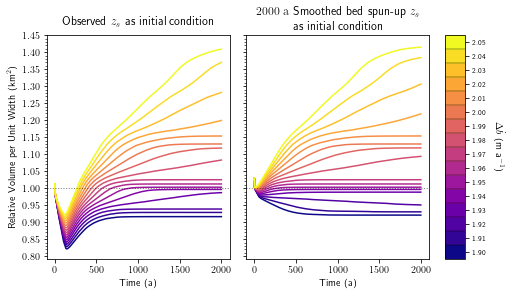

In [6]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(7, 4), constrained_layout=True)


for delta_mb in Observed_IC.Delta_MB:
    color = colormap(normalize(delta_mb))
    
    ax[0].plot(OIC_vol.t[1:], 
               OIC_vol.sel(Delta_MB=delta_mb)[1:],
               color=color)
    
    ax[1].plot(SIC_vol.t[1:], 
               SIC_vol.sel(Delta_MB=delta_mb)[1:], 
               color=color,
               label=delta_mb.values)

ax[0].axhline(1.0,c='k',ls=':',lw=1, alpha=0.5)
ax[1].axhline(1.0,c='k',ls=':',lw=1, alpha=0.5)

cbar = fig.colorbar(s_map, 
                    spacing='proportional', 
                    ticks=OIC_vol.Delta_MB, 
                    ax=ax, 
                    boundaries=boundaries, 
                    drawedges=True, 
                    format='%2.2f')

cbar.set_label('$\Delta \dot b$ (m a$^{-1}$)', rotation=270, labelpad=20)
cbar.ax.tick_params(labelsize=7) 

# Major ticks every 20, minor ticks every 5
major_ticks = np.arange(0.8, 1.50, 0.05)
minor_ticks = np.arange(0.8, 1.45, 0.01)

ax[0].set_yticks(major_ticks)
ax[0].set_yticks(minor_ticks, minor=True)
ax[1].set_yticks(major_ticks)
ax[1].set_yticks(minor_ticks, minor=True)

ax[0].set_title(r'\begin{center} Observed $z_s$ as initial condition \end{center}',pad = 10.0)
ax[1].set_title(r'\begin{center} $2000 \; \rm{a}$ Smoothed bed spun-up $z_s$ \\ as initial condition \end{center}',pad = 20.0)

ax[0].set_ylabel('Relative Volume per Unit Width (km$^2$)')
ax[0].set_xlabel('Time (a)')
ax[1].set_xlabel('Time (a)')

#fig.savefig('../plots/farinotti_corrected/dx50/hysteresis/Vol_1.9--2.0.png', dpi=400, bbox_inches='tight', facecolor='w')

Text(0.2, 0.8, 'Spun-Up Initial Condition')

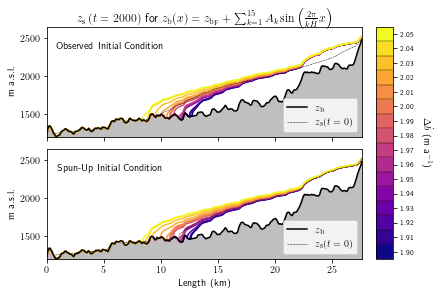

In [7]:
fig, ax = plt.subplots(2,1, sharey=True, sharex=True, constrained_layout=True)


for delta_mb in Observed_IC.Delta_MB:
    color = colormap(normalize(delta_mb))
    
    
    ax[0].plot(Observed_IC.x/1000., 
               Observed_IC.isel(t=-1).sel(Delta_MB=delta_mb).z_s,
               color=color)
    
    ax[1].plot(SmoothBed_SS_IC.x/1000., 
               SmoothBed_SS_IC.isel(t=-1).sel(Delta_MB=delta_mb).z_s,
               color=color)
    
    
ax[0].plot(Observed_IC.x/1000.,      Observed_IC.isel(t=-1,Delta_MB=0).z_b, 'k', label=r'$z_{\rm b}$')
ax[0].plot(Observed_IC.x/1000.,      Observed_IC.isel(t=1,Delta_MB=0).z_s, c='k', ls='--', lw=0.5, label=r'$z_{\rm s}(t=0)$')
ax[0].fill_between(Observed_IC.x/1000., Observed_IC.isel(t=0,Delta_MB=0).z_b, color='gray', alpha=0.5)
ax[0].set_xlim(0,np.max(Observed_IC.x)/1000.)
ax[0].set_ylim(1200, None)
ax[0].set_ylabel('m a.s.l.')

ax[1].plot(SmoothBed_SS_IC.x/1000.,  SmoothBed_SS_IC.isel(t=-1,Delta_MB=0).z_b, 'k', label=r'$z_{\rm b}$')
ax[1].plot(SmoothBed_SS_IC.x/1000.,  SmoothBed_SS_IC.isel(t=1, Delta_MB=0).z_s, c='k', ls='--', lw=0.5, label=r'$z_{\rm s}(t=0)$')
ax[1].fill_between(Observed_IC.x/1000., Observed_IC.isel(t=0,Delta_MB=0).z_b, color='gray', alpha=0.5)
ax[1].set_xlabel('Length (km)')
ax[1].set_ylabel('m a.s.l.')

ax[0].legend(loc=4)
ax[1].legend(loc=4)

cbar = fig.colorbar(s_map, 
                    spacing='proportional', 
                    ticks=OIC_vol.Delta_MB, 
                    ax=ax, 
                    boundaries=boundaries, 
                    drawedges=True, 
                    format='%2.2f')

cbar.set_label('$\Delta \dot b$ (m a$^{-1}$)', rotation=270, labelpad=20)
cbar.ax.tick_params(labelsize=7) 


ax[0].set_title(r'$z_{\rm s} \left( t=2000 \right)$ for $z_{\rm b}(x) = z_{\rm b_{\rm F}} + \sum_{k=1}^{15} A_{k} \sin \left( \frac{2 \pi}{k \tilde H} x \right)$')
            
ax[0].text(0.20,0.8,
             'Observed Initial Condition',
             transform=ax[0].transAxes, horizontalalignment='center')

ax[1].text(0.20,0.8,
             'Spun-Up Initial Condition',
             transform=ax[1].transAxes, horizontalalignment='center')

#fig.tight_layout()
#fig.savefig('../plots/farinotti_corrected/dx50/hysteresis/Final_Zs_1.90--2.00.png', dpi=400, bbox_inches='tight', facecolor='w')

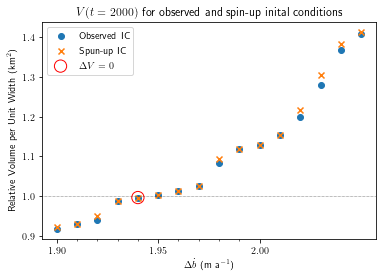

In [8]:
fig, ax = plt.subplots(1,1)


ax.scatter(OIC_vol.Delta_MB, OIC_vol.isel(t=-1),label='Observed IC')
ax.scatter(SIC_vol.Delta_MB, SIC_vol.isel(t=-1),label='Spun-up  IC',marker='x')

ax.legend()

ax.scatter(OIC_vol.isel(Delta_MB=4).Delta_MB, 
           OIC_vol.isel(Delta_MB=4).isel(t=-1), 
           s=150, edgecolors='r', facecolor='None',
           label='$\Delta V = 0$')


ax.axhline(1.0, ls=':', c='k', lw=0.5)

ax.set_title( '$V(t=2000)$ for observed and spin-up inital conditions')
ax.set_ylabel('Relative Volume per Unit Width (km$^2$)')
ax.set_xlabel('$\Delta \dot b$ (m a$^{-1}$)')

# Major ticks every 20, minor ticks every 5
major_ticks = np.arange(1.90, 2.00, 0.05)
minor_ticks = np.arange(1.90, 2.00, 0.01)

ax.set_xticks(major_ticks);
ax.set_xticks(minor_ticks, minor=True);


ax.legend()

#fig.savefig('../plots/farinotti_corrected/dx50/hysteresis/V(t=2000).png', dpi=400, bbox_inches='tight', facecolor='w')

In [129]:
np.linalg.norm((OIC_vol.isel(Delta_MB=4) - SIC_vol.isel(Delta_MB=4)).data, np.infty)

0.13850983551746177

In [115]:
# Percent difference in final volume 
PD = (np.abs(OIC_vol.isel(t=-1) - SIC_vol.isel(t=-1)) / ((OIC_vol.isel(t=-1) + SIC_vol.isel(t=-1))/2)*100).data
# Percent change in final volume 
PC = ((np.abs(OIC_vol.isel(t=-1) - SIC_vol.isel(t=-1)) / SIC_vol.isel(t=-1))*100).data 

print(' ')
print('  --------------------------------------------' )
print('  Percent difference (%) of V(t=-1):' )
print('  --------------------------------------------' )
print('  ')
print('  \tMin    : {:5.2e} (%)'.format(PD.min()))
print('  \tMax    : {:5.2f}    (%)'.format(PD.max()))
print('  \tMean   : {:5.2f}    (%)'.format(PD.mean()))
print('  \tMedian : {:5.2f}    (%)'.format(np.median(PD)))
print('  \tSTD    : {:5.2f}    (%)'.format(np.std(PD, ddof=1)))
print(' ')

 
  --------------------------------------------
  Percent difference (%) of V(t=-1):
  --------------------------------------------
  
  	Min    : 4.68e-07 (%)
  	Max    :  1.89    (%)
  	Mean   :  0.51    (%)
  	Median :  0.17    (%)
  	STD    :  0.64    (%)
 


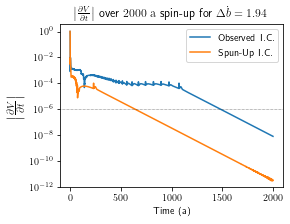

In [14]:
fig, ax = plt.subplots(1,1, figsize=(4,3))

ax.plot(OIC_vol.t, np.abs(OIC_vol.isel(Delta_MB=4).differentiate('t')), label='Observed I.C.')
ax.plot(SIC_vol.t, np.abs(SIC_vol.isel(Delta_MB=4).differentiate('t')), label='Spun-Up I.C.')
ax.legend()

ax.set_title( r'$\left| \frac{\partial V}{\partial t} \right|$ over $2000 \; \rm{a}$ spin-up for $\Delta \dot b = 1.94$')
ax.set_ylabel(r'$\left| \frac{\partial V}{\partial t} \right|$', fontsize='x-large')
ax.set_xlabel('Time (a)')

ax.axhline(10e-7, ls=':', c='k', lw=0.5)
ax.set_yscale('log')
ax.set_ylim(10e-13, None)
fig.savefig('../plots/farinotti_corrected/dx50/hysteresis/dVdt_delta_MB=1.94.png', dpi=400, bbox_inches='tight', facecolor='w')

In [99]:
dVdt_t   = OIC_vol.t.data
dVdt_OIC = np.abs(OIC_vol.isel(Delta_MB=4).differentiate('t')).data
dVdt_SIC = np.abs(SIC_vol.isel(Delta_MB=4).differentiate('t')).data

print(' ')
print('  --------------------------------------------' )
print('  Convergence (dV/dt <= 1e-6) time comparison:' )
print('  --------------------------------------------' )
print('  ')
print('  \tTime (y) to reach Convergence:')
print('  \t----------------------------- ')
print('  \t\t Observed IC : {:4.0f} (y)'.format(dVdt_t[dVdt_OIC<=1e-6][0]))
print('  \t\t Spun-Up  IC : {:4.0f} (y)'.format(dVdt_t[dVdt_SIC<=1e-6][0]))
print('  ')
print('  \tSpeed up of Spun-Up IC       :')
print('  \t----------------------------- ')
print('  \t\t Speed-up    : {:4.2f} (times)'.format(dVdt_t[dVdt_OIC<=1e-6][0]/ dVdt_t[dVdt_SIC<=1e-6][0]))
print(' ')

 
  --------------------------------------------
  Convergence (dV/dt <= 1e-6) time comparison:
  --------------------------------------------
  
  	Time (y) to reach Convergence:
  	----------------------------- 
  		 Observed IC : 1484 (y)
  		 Spun-Up  IC :  643 (y)
  
  	Speed up of Spun-Up IC       :
  	----------------------------- 
  		 Speed-up    : 2.31 (times)
 
